In [1]:
#This is a copy of Lazy Programmer's 'poetry.py' from Advanced NLP course (nlp3)
from __future__ import print_function, division
from builtins import range, input
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.optimizers import Adam, SGD

2023-11-08 15:05:33.491248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

In [4]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 200
LATENT_DIM = 25

In [5]:
# load in the data
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue

  input_line = '<sos> ' + line
  target_line = line + ' <eos>'

  input_texts.append(input_line)
  target_texts.append(target_line)


all_lines = input_texts + target_texts

In [6]:
target_texts

['Two roads diverged in a yellow wood, <eos>',
 'And sorry I could not travel both <eos>',
 'And be one traveler, long I stood <eos>',
 'And looked down one as far as I could <eos>',
 'To where it bent in the undergrowth; <eos>',
 'Then took the other, as just as fair, <eos>',
 'And having perhaps the better claim <eos>',
 'Because it was grassy and wanted wear, <eos>',
 'Though as for that the passing there <eos>',
 'Had worn them really about the same, <eos>',
 'And both that morning equally lay <eos>',
 'In leaves no step had trodden black. <eos>',
 'Oh, I kept the first for another day! <eos>',
 'Yet knowing how way leads on to way <eos>',
 'I doubted if I should ever come back. <eos>',
 'I shall be telling this with a sigh <eos>',
 'Somewhere ages and ages hence: <eos>',
 'Two roads diverged in a wood, and I, <eos>',
 'I took the one less traveled by, <eos>',
 'And that has made all the difference. <eos>',
 'Whose woods these are I think I know. <eos>',
 'His house is in the villa

# Tokenizing

In [7]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE, filters='')

In [8]:
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)


In [9]:
target_sequences

[[104, 537, 538, 9, 7, 539, 540, 2],
 [5, 541, 6, 65, 31, 934, 141, 2],
 [5, 27, 24, 935, 152, 6, 221, 2],
 [5, 167, 67, 24, 17, 128, 17, 6, 65, 2],
 [4, 40, 11, 936, 9, 3, 937, 2],
 [91, 189, 3, 542, 17, 77, 17, 938, 2],
 [5, 142, 265, 3, 222, 939, 2],
 [319, 11, 14, 543, 5, 223, 940, 2],
 [122, 17, 15, 13, 3, 544, 55, 2],
 [23, 545, 52, 404, 111, 3, 546, 2],
 [5, 141, 13, 941, 942, 405, 2],
 [9, 943, 42, 547, 23, 944, 548, 2],
 [549, 6, 266, 3, 224, 15, 267, 945, 2],
 [153, 946, 92, 81, 947, 18, 4, 81, 2],
 [6, 948, 28, 6, 123, 154, 78, 268, 2],
 [6, 190, 27, 949, 53, 19, 7, 950, 2],
 [550, 551, 5, 551, 951, 2],
 [104, 537, 538, 9, 7, 540, 5, 952, 2],
 [6, 189, 3, 24, 406, 953, 954, 2],
 [5, 13, 93, 82, 21, 3, 955, 2],
 [225, 226, 320, 59, 6, 72, 6, 269, 2],
 [26, 96, 32, 9, 3, 956, 957, 2],
 [12, 79, 31, 38, 25, 958, 68, 2],
 [4, 407, 26, 226, 959, 35, 19, 270, 2],
 [44, 143, 552, 73, 72, 11, 960, 2],
 [4, 321, 271, 7, 961, 227, 2],
 [228, 3, 226, 5, 962, 553, 2],
 [3, 963, 554, 8, 

In [10]:
#find max seq length
max_seq_len = max(len(s) for s in input_sequences)
print('Max sequence is:', max_seq_len)

Max sequence is: 12


In [11]:
word2idx = tokenizer.word_index
print('Found %s unique tokens' %len(word2idx))

Found 3056 unique tokens


In [12]:
word2idx.items()

dict_items([('<sos>', 1), ('<eos>', 2), ('the', 3), ('to', 4), ('and', 5), ('i', 6), ('a', 7), ('of', 8), ('in', 9), ('you', 10), ('it', 11), ('he', 12), ('that', 13), ('was', 14), ('for', 15), ('but', 16), ('as', 17), ('on', 18), ('with', 19), ('what', 20), ('all', 21), ('they', 22), ('had', 23), ('one', 24), ('me', 25), ('his', 26), ('be', 27), ('if', 28), ('have', 29), ('we', 30), ('not', 31), ('is', 32), ('from', 33), ('she', 34), ('up', 35), ('out', 36), ('like', 37), ('see', 38), ('or', 39), ('where', 40), ('at', 41), ('no', 42), ('when', 43), ('my', 44), ('her', 45), ('so', 46), ('by', 47), ('some', 48), ("it's", 49), ('him', 50), ("don't", 51), ('them', 52), ('this', 53), ('were', 54), ('there', 55), ('been', 56), ('can', 57), ('too', 58), ('are', 59), ('tell', 60), ("he's", 61), ('do', 62), ('old', 63), ("'i", 64), ('could', 65), ('know', 66), ('down', 67), ('here', 68), ('an', 69), ('off', 70), ('your', 71), ('think', 72), ('must', 73), ('only', 74), ('make', 75), ('let', 76)

In [13]:
word2idx.get('town')

148

In [14]:
#PADDING
max_seq_length = min(max_seq_len, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen = max_seq_length, padding = 'post')
target_sequences = pad_sequences(target_sequences, maxlen = max_seq_length, padding = 'post')

# Pretrained Glove to use in the Embedding layer

In [15]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [16]:
len(word2vec.get('roads')), word2vec.get('roads')

(50,
 array([ 0.66258 ,  0.2123  ,  0.77968 , -0.29735 , -1.7562  , -0.25392 ,
        -0.9175  , -0.12077 ,  0.082226, -1.4477  , -0.87622 , -0.61384 ,
        -0.18897 , -0.92008 , -0.76244 ,  0.412   ,  0.50552 ,  0.23814 ,
         0.69856 , -0.66039 ,  0.25735 , -0.21809 , -0.34929 ,  0.39163 ,
         0.56563 , -0.14954 ,  0.5056  ,  0.79658 ,  1.5936  , -0.1479  ,
         3.2168  ,  0.17621 ,  0.38781 , -0.23386 ,  0.27452 ,  0.94828 ,
         0.27032 , -0.003935, -0.49437 ,  1.4444  , -0.78306 , -0.14778 ,
         0.89745 , -0.20894 , -0.56203 ,  0.015886, -0.71619 , -0.99149 ,
         0.79767 , -0.9672  ], dtype=float32))

In [17]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print('There are %s words' %num_words)

for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...
There are 3000 words


In [18]:
embedding_matrix[10]

array([-1.09190005e-03,  3.33240002e-01,  3.57430011e-01, -5.40409982e-01,
        8.20320010e-01, -4.93910015e-01, -3.25879991e-01,  1.99720007e-03,
       -2.38289997e-01,  3.55540007e-01, -6.06549978e-01,  9.89319980e-01,
       -2.17859998e-01,  1.12360001e-01,  1.14940000e+00,  7.32840002e-01,
        5.11820018e-01,  2.92869985e-01,  2.83879995e-01, -1.35899997e+00,
       -3.79509985e-01,  5.09429991e-01,  7.07099974e-01,  6.29410028e-01,
        1.05340004e+00, -2.17560005e+00, -1.32040000e+00,  4.00009990e-01,
        1.57410002e+00, -1.65999997e+00,  3.77209997e+00,  8.69490027e-01,
       -8.04390013e-01,  1.83899999e-01, -3.43320012e-01,  1.07140001e-02,
        2.39690006e-01,  6.67480007e-02,  7.01170027e-01, -7.37020016e-01,
        2.08770007e-01,  1.15640000e-01, -1.51899993e-01,  8.59080017e-01,
        2.26199999e-01,  1.65189996e-01,  3.63090008e-01, -4.56970006e-01,
       -4.89690006e-02,  1.13160002e+00])

# Neural network model with Embedding layer

In [19]:
# load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  trainable=False
)

In [20]:
# create an LSTM network with a single LSTM
#There are 3 inputs:
#1. input state
input_ = Input(shape=(max_seq_length,))
#2. hidden state of LSTM
initial_h = Input(shape=(LATENT_DIM,))
#3. cell state of LSTM
initial_c = Input(shape=(LATENT_DIM,))
#Embedding layer
x = embedding_layer(input_)
#LSTM layer
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
#Dense layer
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 50)       150000      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                              

2023-11-08 15:05:45.574276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-08 15:05:45.576474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-08 15:05:45.578993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [21]:
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

/Users/hldao/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
# one-hot the targets (can't use sparse cross-entropy)
one_hot_targets = np.zeros((len(input_sequences), max_seq_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [23]:
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/200


2023-11-08 15:05:46.638034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-08 15:05:46.640571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-08 15:05:46.642447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 5.3878 - accuracy: 0.0254

2023-11-08 15:05:50.140622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-08 15:05:50.142614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-08 15:05:50.144637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 4s 222ms/step - loss: 5.3878 - accuracy: 0.0254 - val_loss: 5.0426 - val_accuracy: 0.0226
Epoch 2/200
9/9 [==============================] - 2s 175ms/step - loss: 4.5956 - accuracy: 0.0446 - val_loss: 4.7431 - val_accuracy: 0.0833
Epoch 3/200
9/9 [==============================] - 1s 138ms/step - loss: 4.3756 - accuracy: 0.0833 - val_loss: 4.7915 - val_accuracy: 0.0833
Epoch 4/200
9/9 [==============================] - 1s 136ms/step - loss: 4.3321 - accuracy: 0.0833 - val_loss: 4.8302 - val_accuracy: 0.0833
Epoch 5/200
9/9 [==============================] - 1s 146ms/step - loss: 4.3255 - accuracy: 0.0833 - val_loss: 4.8217 - val_accuracy: 0.0833
Epoch 6/200
9/9 [==============================] - 1s 124ms/step - loss: 4.3040 - accuracy: 0.0833 - val_loss: 4.7743 - val_accuracy: 0.0833
Epoch 7/200
9/9 [==============================] - 1s 118ms/step - loss: 4.2729 - accuracy: 0.0833 - val_loss: 4.7255 - val_accuracy: 0.0833
Epoch 8/200
9/9 [========

Epoch 59/200
9/9 [==============================] - 1s 109ms/step - loss: 2.9326 - accuracy: 0.1905 - val_loss: 4.8331 - val_accuracy: 0.0969
Epoch 60/200
9/9 [==============================] - 1s 111ms/step - loss: 2.9111 - accuracy: 0.1916 - val_loss: 4.8473 - val_accuracy: 0.0964
Epoch 61/200
9/9 [==============================] - 1s 112ms/step - loss: 2.8883 - accuracy: 0.1935 - val_loss: 4.8564 - val_accuracy: 0.0966
Epoch 62/200
9/9 [==============================] - 1s 110ms/step - loss: 2.8678 - accuracy: 0.1957 - val_loss: 4.8649 - val_accuracy: 0.0961
Epoch 63/200
9/9 [==============================] - 1s 113ms/step - loss: 2.8472 - accuracy: 0.1972 - val_loss: 4.8768 - val_accuracy: 0.0943
Epoch 64/200
9/9 [==============================] - 1s 116ms/step - loss: 2.8268 - accuracy: 0.1970 - val_loss: 4.8798 - val_accuracy: 0.0958
Epoch 65/200
9/9 [==============================] - 1s 112ms/step - loss: 2.8060 - accuracy: 0.1990 - val_loss: 4.8855 - val_accuracy: 0.0946
Epoch 

9/9 [==============================] - 1s 108ms/step - loss: 1.8837 - accuracy: 0.3127 - val_loss: 6.4277 - val_accuracy: 0.0825
Epoch 174/200
9/9 [==============================] - 1s 110ms/step - loss: 1.8792 - accuracy: 0.3138 - val_loss: 6.4582 - val_accuracy: 0.0822
Epoch 175/200
9/9 [==============================] - 1s 107ms/step - loss: 1.8721 - accuracy: 0.3142 - val_loss: 6.4446 - val_accuracy: 0.0830
Epoch 176/200
9/9 [==============================] - 1s 115ms/step - loss: 1.8657 - accuracy: 0.3174 - val_loss: 6.4692 - val_accuracy: 0.0819
Epoch 177/200
9/9 [==============================] - 1s 109ms/step - loss: 1.8600 - accuracy: 0.3179 - val_loss: 6.4919 - val_accuracy: 0.0828
Epoch 178/200
9/9 [==============================] - 1s 104ms/step - loss: 1.8521 - accuracy: 0.3183 - val_loss: 6.4899 - val_accuracy: 0.0822
Epoch 179/200
9/9 [==============================] - 1s 114ms/step - loss: 1.8477 - accuracy: 0.3196 - val_loss: 6.5309 - val_accuracy: 0.0833
Epoch 180/200

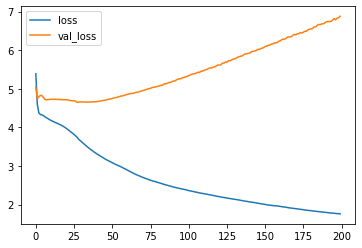

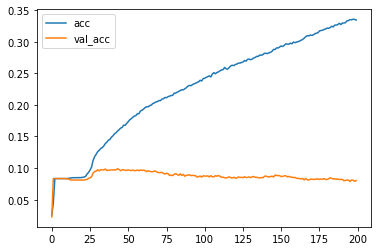

In [24]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Make a sampling model

In [25]:
# make a sampling model
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])

2023-11-08 15:09:17.208549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-08 15:09:17.211277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-08 15:09:17.213527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [26]:
sampling_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          multiple             150000      ['input_4[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                            

In [27]:
# reverse word2idx dictionary to get back words
# during prediction
idx2word = {v:k for k, v in word2idx.items()}

In [33]:
def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_seq_length):
    o, h, c = sampling_model.predict([np_input, h, c], verbose = 0)
    #o is the list of probabilities for the next word
    #this is where we take a sample from
    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [34]:
# generate a 4 line poem
while True:
  for _ in range(8):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break


i invested there is out of snow!
happens to cool the poetess's outrage?
i had the tender verse escaped their outrage?
on the cellar hole in every lifelike posture they find see?
then it looked a matter of dishes
'it rests with carried revolving it had the way to-day?'
till the one traveler, long ago and i—' came fresh
'cross lots, 'cross button, 'cross everything,
---generate another? [Y/n]---y
not lupine living of the road he chose,
glass why away
well, the ominous stain of plenty,
to blow every way he had me?'
when of the band-music playing.
that took the wear of spray;
'it's raining.'
and blew him for me my tent deep '
---generate another? [Y/n]---n
